In [1]:
import os
import re
import time
import json
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import os.path as osp

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import torch
from torch.utils.data import DataLoader
# from torchsummary import summary

from dataset import E33OMA
from utils import seed, load_checkpoint, plot_global_ave, qqplot, find_nearest, plot_on_grid, make_saving_path

In [2]:
from model import STMLightning

### Load Dataset and Model

In [7]:
dataset = E33OMA(period='test', species='bcb', padding=(160, 160), sequence_length=48)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False) # for in_channel=6, batch_size MUST be 1

In [4]:
checkpoint_path="tb_logs/EncDecConvLSTM-V01-02042025/version_0/checkpoints/epoch=49-step=98550.ckpt"
checkpoint = torch.load(checkpoint_path, weights_only=True)

In [5]:
net = STMLightning.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    in_channels=5,          # Specify the input channels used during training
    out_channels=64,  # Specify the hidden channels
    kernel_size=3,     # Specify the kernel sizes
)
net.eval()

STMLightning(
  (model): EncDecConvLSTM(
    (encoder): Encoder(
      (conv1): ConvLayer(
        (conv): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(2, 64, eps=1e-05, affine=True)
        (act): SiLU(inplace=True)
      )
      (conv2): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): GroupNorm(2, 64, eps=1e-05, affine=True)
        (act): SiLU(inplace=True)
      )
      (conv3): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(2, 64, eps=1e-05, affine=True)
        (act): SiLU(inplace=True)
      )
      (conv4): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): GroupNorm(2, 64, eps=1e-05, affine=True)
        (act): SiLU(inplace=True)
      )
    )
    (decoder): Decoder(
      (conv1): ConvTransposeLayer(
        (conv): Sequential(
          (0): 

In [8]:
# Preallocation
total_samples = len(dataloader.dataset)
GTs = np.empty((total_samples, 1, 1, 90, 144))
PDs = np.empty((total_samples, 1, 1, 90, 144))

net.eval()

sample_index = 0
with torch.no_grad():
    for counter, (X, y) in enumerate(dataloader, 1):

        batch_size = X.shape[0]

        X = X.cuda()        
        y = y.cuda()

        p = net(X)
        p = p[..., 35:35+90, 8:8+144].clone()

        GTs[sample_index:sample_index+batch_size] = (y.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean
        PDs[sample_index:sample_index+batch_size] = (p.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean
        
        sample_index += batch_size
        
print(GTs.shape, PDs.shape)

(17473, 1, 1, 90, 144) (17473, 1, 1, 90, 144)


In [9]:
snapshot_dir = './tb_logs/EncDecConvLSTM-V01-02042025'
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode = 'wb') as f:

    np.save(f, GTs)
    np.save(f, PDs)

In [ ]:
with open(osp.join(snapshot_dir, 'test-results.npy'), mode='rb') as f:
    
    GTs = np.load(f, allow_pickle=True)
    PDs = np.load(f, allow_pickle=True)

print(GTs.shape, PDs.shape)

In [10]:
def r_squared_temporal(gts, pds):
    
    import pandas as pd
    r_squared_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())

    return pd.Series(r_squared_temporal)


In [11]:
r_squared_temporal(GTs, PDs).describe()

count    17473.000000
mean         0.675341
std          0.168445
min         -1.107817
25%          0.600317
50%          0.707909
75%          0.788418
max          0.994695
dtype: float64

In [10]:
def scatter_plot(ax, X, y, scale='linear'):

    idx = np.arange(len(X.ravel()))

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v1 = X.ravel()[idx[:10000]]
    v2 = y.ravel()[idx[:10000]]

    max_value = np.array((v1, v2)).max()

    ax.scatter(v1, v2, color='teal', edgecolor='steelblue', alpha=0.5)
    ax.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

    ax.set_xlabel('Ground Truth')
    ax.set_xscale(scale)

    ax.set_ylabel('Prediction')
    ax.set_yscale(scale)

    ax.grid()

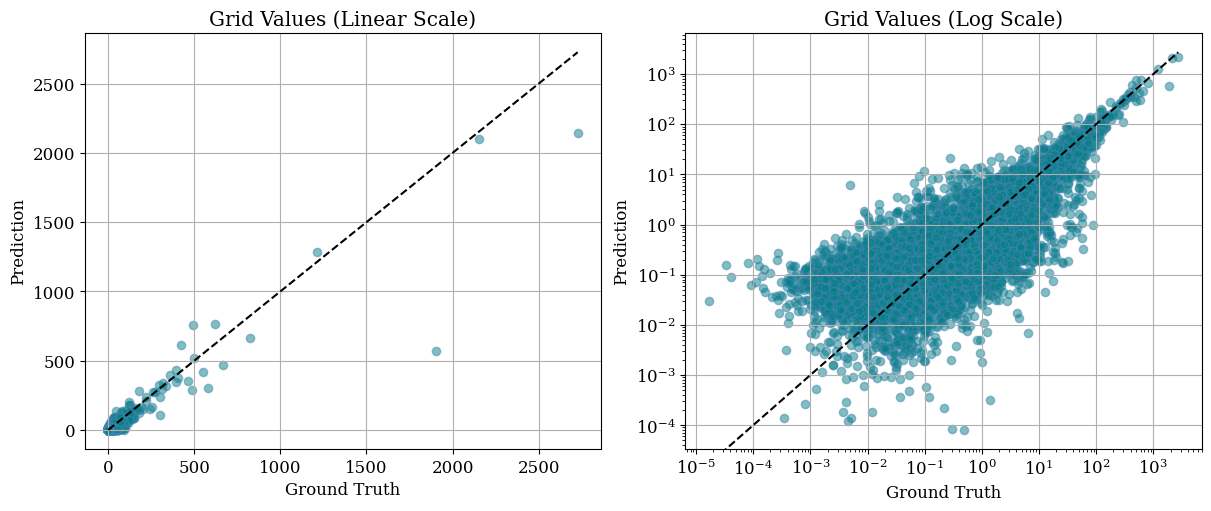

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), constrained_layout=True)

ax1.set_title('Grid Values (Linear Scale)')
scatter_plot(ax1, GTs, PDs, scale='linear')

ax2.set_title('Grid Values (Log Scale)')
scatter_plot(ax2, GTs, PDs, scale='log')

plt.show()

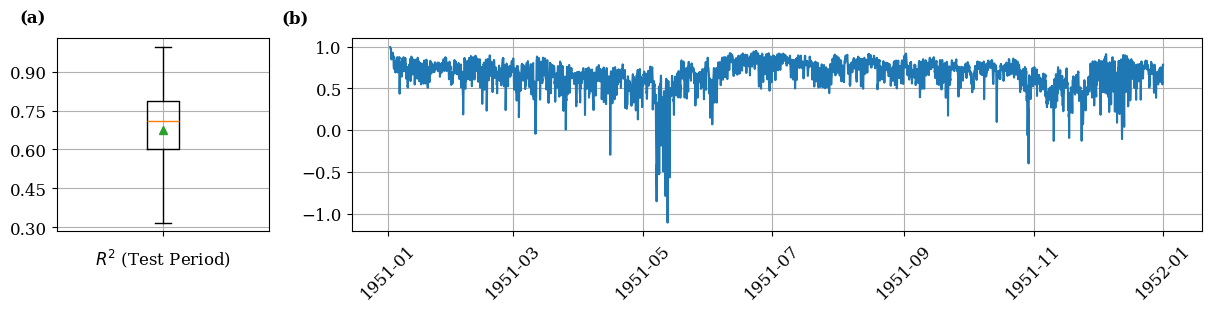

In [12]:
from matplotlib.ticker import MaxNLocator

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

v3 = r_squared_temporal(GTs, PDs)[:]
time = dataset.datetimeindex[:]

ax2.boxplot(v3, showmeans=True, showfliers=False)
ax2.set_xticklabels([])
ax2.set_xlabel(r'$R^2$ (Test Period)')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6)) 
ax2.text(-0.05, 1.15, '(a)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2.grid()

ax3.plot(time, v3)
ax3.tick_params(axis='x', labelrotation=45)
ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

# if save_figure:
#     plt.savefig(osp.join(snapshot_dir, '01-r2_temporal_test.png'))

plt.show()

### Monthly Average Concentration

In [13]:
def r_squared_spatial(gts, pds):

    output = np.empty((gts.shape[1], gts.shape[2]))

    for i in range(gts.shape[1]):
        for j in range(gts.shape[2]):
            output[i, j] = r2_score(gts[:, i, j], pds[:, i, j])
    
    return output

In [14]:
sr2 = r_squared_spatial(GTs.squeeze(), PDs.squeeze())

In [15]:
ds = xr.Dataset({
    'Real Data': (["time", "lat", "lon"], GTs.squeeze()),
    'Model Output': (["time", "lat", "lon"], PDs.squeeze()),
    'Coefficient of Determination': (["lat", "lon"], sr2),

              },
              
     coords=dict(
        time = dataset.datetimeindex,
        lon  = dataset.lon,
        lat  = dataset.lat,
    )
)

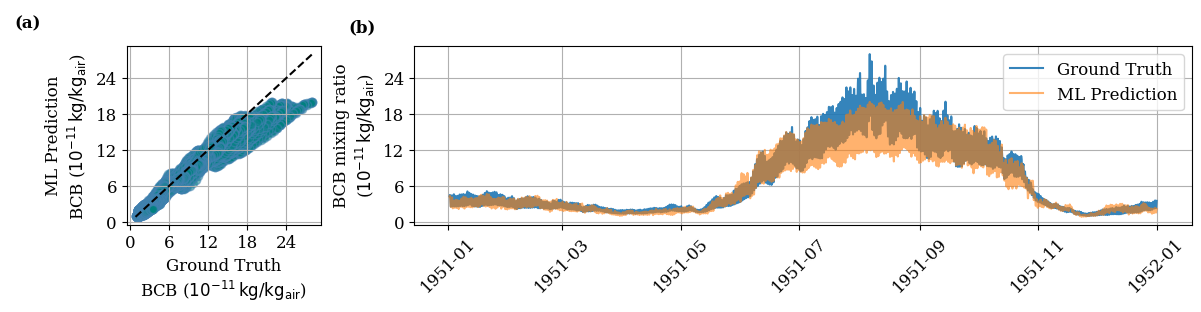

In [16]:
fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))
# ds_monthly_avg = ds_monthly['BCB'].isel(level=0).weighted(weights).mean(dim=("lat", "lon"))

avgGT = ds_avg['Real Data'].values
avgPD = ds_avg['Model Output'].values

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5)) 

# BCB mixing ratio

ax1.set_xlabel(r'Ground Truth' '\n' r'BCB ($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'BCB ($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)

ax1.text(-0.05, 1.15, '(a)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax1.grid()

ax3.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
ax3.plot(dataset.datetimeindex, avgPD, alpha=0.6, label='ML Prediction')
# ax3.plot(ds_monthly_avg['time'][-11:], ds_monthly_avg.values[-11:], color='black', marker='o', markersize=3, linestyle='dashed', alpha=0.8,
        #  label='Monthly Average', zorder=5) #TODO -11/-12

ax3.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax3.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
ax3.tick_params(axis='x', labelrotation=45)

ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

plt.legend()
# if save_figure:
#     plt.savefig(osp.join(snapshot_dir, '02-global_average.png'))

plt.show()

### Exceedence Probability

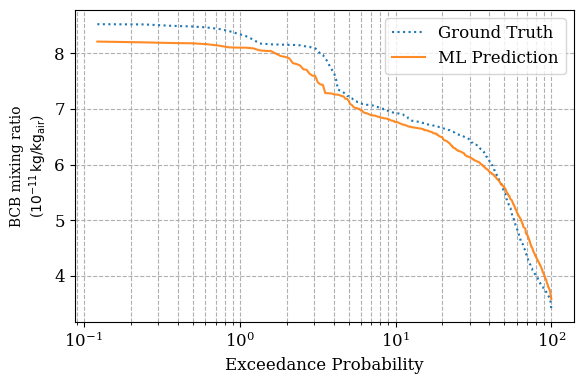

In [18]:
def exceedence_probability(values):
    v = np.array(values)  # Convert to numpy array
    v = -np.sort(-v)  # Sort in descending order
    ep = 100 * np.arange(1, len(v) + 1) / (len(v) + 1)  # Weibull formula
    return v, ep

v1, ep1 = exceedence_probability(avgGT)
v2, ep2 = exceedence_probability(avgPD)

# In case interpolation is needed
# np.interp(0.05, weibull_exceedance_probability, sorted_flow)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the exceedance probabilities
ax.plot(ep1, v1, ':', alpha=1.0, label='Ground Truth')
ax.plot(ep2, v2, '-', alpha=0.9, label='ML Prediction')

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Add labels and title
ax.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=10)
ax.set_xlabel('Exceedance Probability')

# Add grid, legend, and show the plot
ax.grid(True, which="both", ls="--")
ax.legend()
plt.tight_layout()
plt.show()

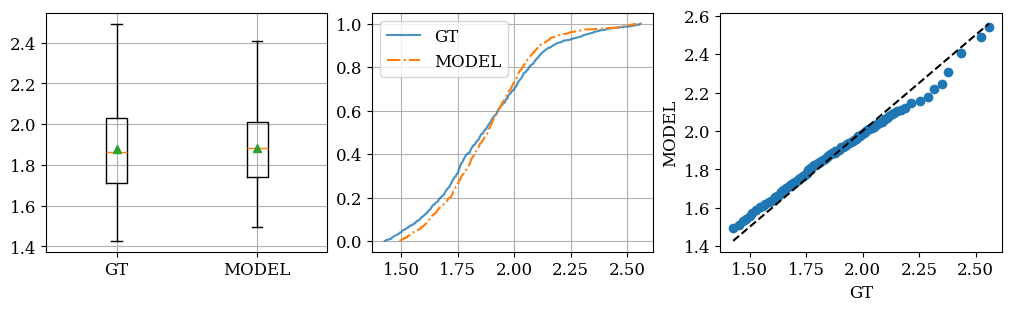

In [27]:
qqplot(avgGT.ravel(), avgPD.ravel(), yax1='' ,axis_names=None, quantiles=100, save_figure=False, fformat=None, saving_path=None)

In [17]:
import geopandas as gpd
from cartopy import crs as ccrs

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

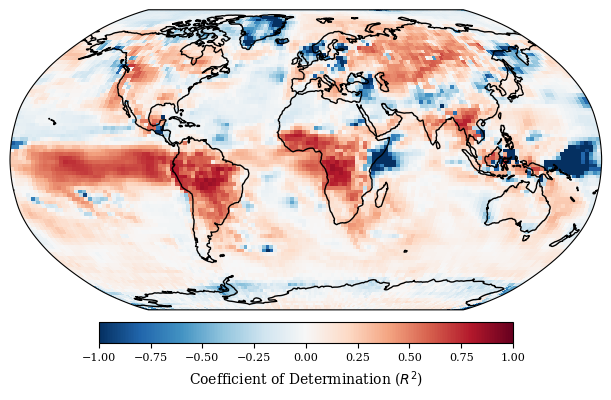

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax.coastlines()

# Get the data for the current level
# data = ds['Coefficient of Determination'].sel(mod='monthly')
data = ds['Coefficient of Determination']

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1.0, vmax=1.0
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# if save_figure:
#     plt.savefig(osp.join(snapshot_dir, '03-r2_spatial_test.png'))

plt.show()

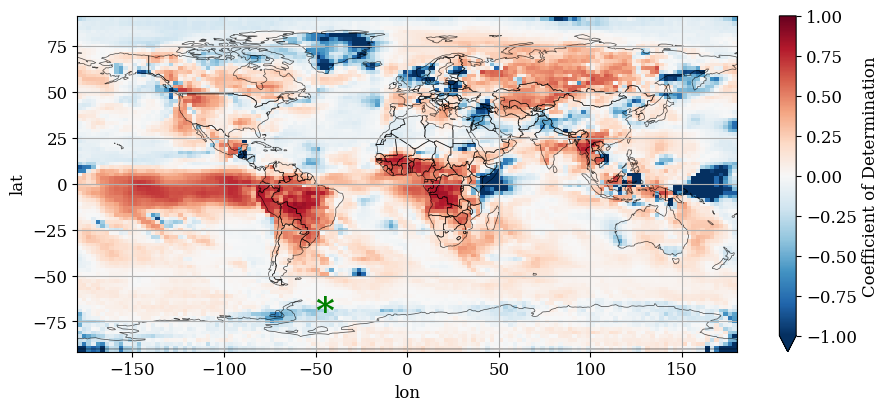

In [19]:
import cartopy
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

# Plot the data
ds['Coefficient of Determination'].plot(ax=ax, add_colorbar=True, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
world.boundary.plot(ax=ax, alpha=0.7, color='black', linewidth=0.5, zorder=1)

ax.text(-50, -75, '*', fontsize=26, color='green', fontweight='bold')

# Show the plot
plt.grid()
plt.show()

In [20]:
df = ds.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
gdf = df.groupby(['lat', 'lon'])
df.head()

,lat,lon,time,Real Data,Model Output,Coefficient of Determination
0,-90.0,-178.75,1951-01-01 23:45:00,0.011994,0.016522,-3.024447
1,-90.0,-178.75,1951-01-02 00:15:00,0.011847,0.018288,-3.024447
2,-90.0,-178.75,1951-01-02 00:45:00,0.011708,0.020221,-3.024447
3,-90.0,-178.75,1951-01-02 01:15:00,0.011576,0.021907,-3.024447
4,-90.0,-178.75,1951-01-02 01:45:00,0.011451,0.022290,-3.024447


In [21]:
def plot_on_grid(gdf, lat, lon, fig_num):

    from matplotlib import rcParams
    from matplotlib.ticker import MaxNLocator
    rcParams['font.size'] = 10  # Set the default font size

    g = gdf.get_group((lat, lon))
    g = g.sort_values('time')

    r2 = g['Coefficient of Determination'].iloc[0]
    print(f'exact coordinates, lat:{lat}, lon:{lon}, R2H: {r2:.2f}')
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    # Rename columns directly in the plot command
    ax.plot(g['time'], g['Real Data'], label='Ground Truth', alpha=1.0)
    ax.plot(g['time'], g['Model Output'], label='ML Prediction', alpha=0.6)
    
    # Set x-ticks to display month names
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45)

    ax.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 

    ax.text(-0.05, 1.08, f'({fig_num})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    # Adjust the font size of the legend
    ax.legend(fontsize=12, loc=2)  # Set the desired font size for the legend

    ax.grid(True)

    # plt.savefig(f'fig05-{fig_num}.svg')
    plt.show()

exact coordinates, lat:-75.0, lon:-51.25, R2H: -0.15


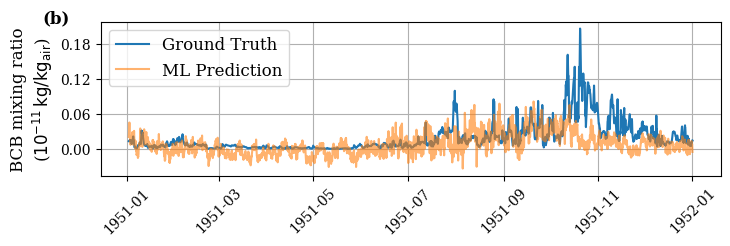

In [22]:
lat, lon = find_nearest(df[['lat', 'lon']], -75, -50)
plot_on_grid(gdf, lat, lon, 'b')